<a href="https://colab.research.google.com/github/nabil4247/DataWarehouse-DataMining/blob/main/%20Movie%20Recommendation%20System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Class Assignment_Workshop on Recommender - Data Warehouse dan Mining
 Tugas ini adalah tugas individual, setiap mahasiswa wajib menyelesaikan task (hands-on exercise) yang diberikan. 
Requirement:

* Pastikan anda telah menginstall Anaconda Navigator di personal computer yang anda miliki. Pastikan JupiterLab atau Jupiter Notebook dapat digunakan.
* Silahkan anda gunakan dataset seperti yang terdapat link tutorial.
* Buatlah recommender system berbasis python untuk tiga kategori berikut (submit file ipynb):
1. Demographic Filtering
2. Content-Based Filtering 
3. Collaborative Filtering


## Load Dataset

Melakukan import `tmdb_5000_credits.csv` dan `tmdb_5000_movies.csv` dari `GoogleDrive()` 

In [ ]:
import pandas as pd 
import numpy as np 
from google.colab import files
df1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/tmdb_5000_credits.csv')
df2=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/tmdb_5000_movies.csv')

## Join the two Dataset

Melakukan join dua dataset `tmdb_5000_credits.csv` dan `tmdb_5000_movies.csv` pada kolom `id` 

In [ ]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

## Peak the data

Menampilkan data sebanyak 5 baris

In [ ]:
df2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


# 01. Demographic Filtering --

Sebelum memulai, diharuskan untuk:

* membutuhkan metrik untuk menilai atau menilai film
* Hitung skor untuk setiap film
* Urutkan skor dan rekomendasikan film berperingkat terbaik kepada pengguna.

In [ ]:
C= df2['vote_average'].mean()
C

6.092171559442011

In [ ]:
m= df2['vote_count'].quantile(0.9)
m

1838.4000000000015

In [ ]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

Define a new feature 'score' and calculate its value with `weighted_rating()`

In [ ]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

## Sort the DataFrame 
berdasarkan score feature dan output dari title, vote count, vote average dan weighted rating atau score of the top 10 movies

* Urutkan film berdasarkan skor yang dihitung di atas
* Menampilkan 10 top film

In [ ]:
q_movies = q_movies.sort_values('score', ascending=False)

q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


## Trending Now tab 

Mencari film yang sangat popular dan diurutkan dengan dataset by the popularity column

Text(0.5, 1.0, 'Popular Movies')

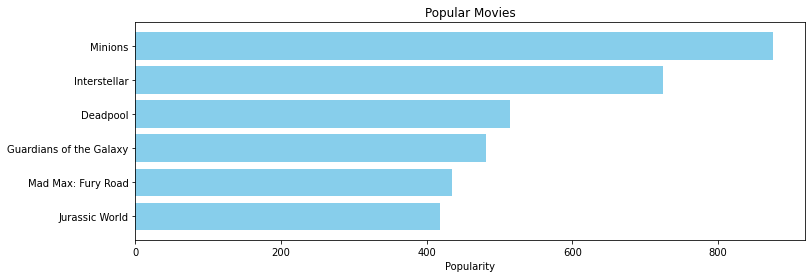

In [ ]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

# 02. Content Based Filtering

Dalam sistem rekomendasi ini, konten film  (overview, cast, crew, keyword, tagline etc) digunakan untuk mencari kesamaannya dengan film lain. Kemudian film-film yang kemungkinan besar mirip direkomendasikan.


## Plot description based Recommender


Melakukan penghitungan skor kesamaan berpasangan untuk semua film berdasarkan deskripsi plotnya dan merekomendasikan film berdasarkan skor kesamaan tersebut.

In [ ]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

## Term Frequency-Inverse Document Frequency (TF-IDF) 

Selanjutnya menghitung TF-IDF pada vectors pada setiap overview

In [ ]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

# Use sklearn's 

`linear_kernel()`  instead of `cosine_similarities()` since it is faster 

In [ ]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

# Define recommendation function

Berikut adalah langkah-langkah berikut yang akan diikuti: 

* Dapatkan indeks film yang diberikan judulnya.
* Dapatkan daftar skor kesamaan kosinus untuk film tertentu dengan semua film. Ubah menjadi daftar tupel di mana elemen pertama adalah posisinya dan yang kedua adalah skor kesamaan.
* Urutkan daftar tupel tersebut berdasarkan skor kesamaan; yaitu, elemen kedua.
* Dapatkan 10 elemen teratas dari daftar ini. Abaikan elemen pertama karena mengacu pada diri sendiri (film yang paling mirip dengan film tertentu adalah film itu sendiri).
* Return judul yang sesuai dengan indeks elemen teratas.

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [ ]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [ ]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

## Credits, Genres and Keywords Based Recommender

Akan membuat sebuah recommender based dari metadata: the 3 top actors, the director, related genres and the movie plot keywords.

In [ ]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [ ]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [ ]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [ ]:
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


## Convert the names and keyword instances into lowercase

Ini dilakukan agar vectorizer kita tidak menghitung Johnny dari "Johnny Depp" dan "Johnny Galecki" sebagai sama.

In [ ]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

## CountVectorizer() instead of TF-IDF

karena tidak ingin meremehkan kehadiran seorang aktor/sutradara jika dia telah berakting atau menyutradarai dalam lebih banyak film. Itu tidak masuk akal secara intuitif.

In [ ]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [ ]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [ ]:
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [ ]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

In [ ]:
get_recommendations('The Godfather', cosine_sim2)

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: title, dtype: object

In [ ]:
get_recommendations('Iron Man', cosine_sim2)

79                      Iron Man 2
7          Avengers: Age of Ultron
16                    The Avengers
26      Captain America: Civil War
31                      Iron Man 3
39                    TRON: Legacy
4401           The Helix... Loaded
83                      The Lovers
193                    After Earth
4117            Six-String Samurai
Name: title, dtype: object

# 03. Collaborative Filtering

Akan menggunakan sebuah teknik bernama Collaborative Filtering untuk membuat recommendations pada Movie Watchers. yang memiliki dua tipe yaitu:

* User based filtering: Sistem ini merekomendasikan produk kepada pengguna yang disukai pengguna serupa. Untuk mengukur kesamaan antara dua pengguna, kita dapat menggunakan korelasi pearson atau kesamaan kosinus

* Item Based Collaborative Filtering: Alih-alih mengukur kesamaan antar pengguna, CF berbasis item merekomendasikan item berdasarkan kesamaannya dengan item yang dinilai pengguna target. Demikian juga, kesamaan dapat dihitung dengan Korelasi Pearson atau Persamaan Cosinus.

## Single Value Decomposition

Untuk mengubah masalah rekomendasi menjadi masalah optimasi. dapat melihatnya sebagai seberapa baik dalam memprediksi peringkat untuk item yang diberikan pengguna. Salah satu metrik umum adalah Root Mean Square Error (RMSE). Semakin rendah RMSE, semakin baik kinerjanya.

In [ ]:
pip install numpy

In [ ]:
pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 5.5 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617791 sha256=53fe1a69a7a48f075e066ae605992e155fd327d47929b6de321e3fd8067f7bc8
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import Reader
from surprise import Dataset
from surprise import SVD
from surprise.model_selection import cross_validate
reader = Reader()
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Perhatikan bahwa dalam film dataset ini dinilai pada skala 5 tidak seperti yang sebelumnya.

In [ ]:
from surprise.model_selection import KFold
ratings =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/ratings_small.csv')
data = Dataset.load_from_df(ratings[['userId','movieId','rating']],reader)
kf = KFold(n_splits=5)
kf.split(data)

<generator object KFold.split at 0x7fc0cfba7950>

In [ ]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'fit_time': (5.282896041870117,
  5.260739326477051,
  5.403660774230957,
  5.326586484909058,
  5.542859077453613),
 'test_mae': array([0.69261613, 0.6967976 , 0.68842952, 0.69476258, 0.68523518]),
 'test_rmse': array([0.89889543, 0.90477767, 0.89164914, 0.90150245, 0.89367027]),
 'test_time': (0.3138430118560791,
  0.1813335418701172,
  0.3029658794403076,
  0.18772339820861816,
  0.33996081352233887)}

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Pilih pengguna dengan ID pengguna 1 dan periksa peringkat yang dia berikan

In [ ]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.6830800014190683, details={'was_impossible': False})

Untuk film dengan ID 302, didapatkan perkiraan prediksi 2,618. Salah satu fitur yang mengejutkan dari sistem rekomendasi ini adalah tidak peduli apa filmnya (atau apa isinya). Ini bekerja murni berdasarkan ID film yang ditetapkan dan mencoba memprediksi peringkat berdasarkan bagaimana pengguna lain memprediksi film.

# Conclusion

Recommenders menggunakan pemfilteran demografis, berbasis konten, dan kolaboratif. 

Pemfilteran demografis sangat mendasar dan tidak dapat digunakan secara praktis, Sistem Hybrid dapat memanfaatkan pemfilteran berbasis konten dan kolaboratif karena kedua pendekatan tersebut terbukti hampir saling melengkapi. 

Adapun tugas latihan ini mengacu pada:

https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system


Beberapa perubahan code yang ada pada Kaggle, didapatkan dari stackoverflow berikut:

https://stackoverflow.com/questions/61305393/svd-has-no-split-attribute

https://stackoverflow.com/questions/59112197/importerror-cannot-import-name-evaluate-from-surprise-import-evaluate